目的为运用Logistic模型对利差进行建模，核心的问题在于非线性变量的处理。

主要运用的方法是直接分区间dummy，分位数映射和WOE-IV，最后一种最好。

当然也需要进行降维，方法就是PV过滤器

In [ ]:
import pandas as pd
import scorecardpy as sc
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression as Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.metrics import SCORERS
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import pickle
import seaborn as sns
import math
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import timedelta
from datetime import datetime
from sklearn.linear_model import LinearRegression as LR,Ridge,Lasso
def stand_sca(data):
    new_data=(data-data.mean())/data.std()
    return new_data
def lag(df, period, colist):
    df1 = df.copy(deep=True)
    for col in colist:
        df1[col + '-lag' + str(period)] = df1[col].shift(period)
    return df1

In [2]:
def log_map(x):
    if x > 0 :
        return 1
    else:
        return 0
def onehot_encode(df, colnames, cut_type, bin_num):
    df1 = df.copy(deep = True)
    data_onehot = df1
    interval_dic = {}
    for colname in tqdm(colnames):
        if cut_type == 'cut':
            index_list = []
            df1[colname + '_bin'] = pd.cut(df1[colname],bin_num)
            df1 = df1.drop(columns = [colname])
            for i in df1[colname + '_bin'].value_counts().index:
                index_list.append(i)
            interval_dic[colname] = index_list
        if cut_type == 'qcut':
            index_list = []
            df1[colname + '_bin'] = pd.qcut(df1[colname],bin_num,duplicates = 'drop')
            df1 = df1.drop(columns = [colname])
            for i in df1[colname + '_bin'].value_counts().index:
                index_list.append(i)
            interval_dic[colname] = index_list
    data_onehot = pd.get_dummies(df1)
    return data_onehot,interval_dic


def fit_index(x,index_list):
    if x < float(index_list[0].left):
        return index_list[0]
    elif x > float(index_list[-1].right):
        return index_list[-1]
    else:
        for idx in index_list:
            if x in idx:
                return idx
        print(x)

def tree_f(x,index_list):
    if x < float(index_list[0].left):
        return index_list[0]
    elif x > float(index_list[-1].right):
        return index_list[-1]
    else:
        for idx in index_list:
            if x in idx:
                return idx
        print(x)
        
def onehot_fit(feature_list,interval_dic, df_fit):
    for feature in tqdm(feature_list):
        tmp_list = interval_dic[feature]
        df_fit[feature + '_bin'] = df_fit[feature].apply(lambda x: fit_index(x, tmp_list)) 
        df_fit[feature + '_bin'] = df_fit[feature + '_bin'].astype('category')
    df_fit = df_fit.drop(columns = feature_list)
    return df_fit

def tree_fit(feature_list,clf_df, df_fit):
    for feature in feature_list:
        tmp_list = clf_df[clf_df['feature'] == feature]
        woe_dict = dict(zip(tmp_list['bins'],tmp_list['woe']))
        tmp_list = clf_df[clf_df['feature'] == feature].bins.to_list()
#         print(woe_dict)
        df_fit[feature + '_woe'] = df_fit[feature].apply(lambda x: tree_f(x, tmp_list)) 
        df_fit[feature + '_woe'] = df_fit[feature + '_woe'].map(woe_dict)
    df_fit = df_fit.drop(columns = feature_list)
    return df_fit

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
def optimal_binning_boundary(x: pd.Series, y: pd.Series, nan: float = -999.) -> list:
    '''
    利用决策树获得最优分箱的边界值列表
    '''
    boundary = []  # 待return的分箱边界值列表

    x = x.fillna(nan).values  # 填充缺失值
    y = y.values

    clf = DecisionTreeClassifier(criterion='gini', max_depth = 3)  
    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
#     tree.plot_tree(clf)
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary


def feature_woe_iv(x: pd.Series, y: pd.Series, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
    '''
    x = x.fillna(nan)
    boundary = optimal_binning_boundary(x, y)  # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)  # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']  # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间,
                                                           # right为False代表右边是开区间
    grouped = df.groupby('bins')['y']  # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('good', lambda y: (y == 0).sum()),
                             ('bad', lambda y: (y == 1).sum()),
                             ('total', 'count')])

    result_df['good_pct'] = result_df['good'] / result_df['good'].sum()  # 好客户占比
    result_df['bad_pct'] = result_df['bad'] / result_df['bad'].sum()  # 坏客户占比
    result_df['total_pct'] = result_df['total'] / result_df['total'].sum()  # 总客户占比

    result_df['bad_rate'] = result_df['bad'] / result_df['total']  # 坏比率

    result_df['woe'] = np.log(result_df['good_pct'] / result_df['bad_pct'])  # WOE
    result_df['iv'] = (result_df['good_pct'] - result_df['bad_pct']) * result_df['woe']  # IV

#     print(f"woe = {result_df['woe'].sum()}")

    return result_df

# 1. 读取数据

In [186]:
#选取筛选后的线性指标
liner_feature_df = pd.read_excel('线性回归指标筛选数据集.xlsx')
#读取钢铁的数据
df = pd.read_csv('panel_钢铁_enrich_v1_all.csv',encoding = 'gbk')
df .rename(columns={'Unnamed: 0':'DATE'},inplace=True)
df['DATE']=df['DATE'].map(lambda x:pd.to_datetime(x)) #Date 数据格式处理（resample步骤需要）
df = df.set_index('DATE')
#筛选掉一些列，只保留有效的X feature
liner_feature = liner_feature_df.columns.to_list()
try:
    liner_feature.remove('Unnamed: 0')
    liner_feature.remove('y1')
    liner_feature.remove('y2')
    liner_feature.remove('y3')
except:
    pass


通过族的匹配获得线性变量，这些性质都比较好，可以直接进行预测。对于非线性的变量，需要单领出来进行处理

In [187]:
#主要要补充变量后缀的识别字符列表
marklist=['_DIFF','_LAG','-']

#LF是特征的名字，mark list是后缀识别表，返回名字中第一次出现这种后缀的位置
#用来去除这些后缀
def getN(LF,marklist):
    n=len(LF)
    #templist是所有包含在特征名字中的后缀
    templist=[m for m in marklist if m in LF]
    if len(templist)>0:
        #n是第一次出现这种后缀的位置
        n=min([LF.index(m) for m in templist])
    return n

liner_feature_cluster=[]
for item in liner_feature:
    #这些名字去除后缀
    liner_feature_cluster.append(item[:getN(item,marklist)])
liner_feature_cluster=list(set(liner_feature_cluster))
#去除后缀后进行了去重，这一步应该是获得类别的名称
liner_feature_cluster
#分别把全部变量和线性变量放入到函数中获取对应的族，再通过数组相减获得非线性族数据
#set([1,2,3,4,5])-set([2,3,4])

#对这些变量名称进行删除后缀处理
all_feature_list=list(df.columns.values)
all_feature_list_cluste=[]
for item in all_feature_list:
    all_feature_list_cluste.append(item[:getN(item,marklist)])
all_feature_list_cluste=list(set(all_feature_list_cluste))
#看一下有哪些变量在liner_feature_cluster中没有
set(all_feature_list_cluste)-set(liner_feature_cluster)

{'k_t',
 'y1',
 'y3',
 '周度_库存:主要钢材品种:合计',
 '周度_螺纹钢:吨毛利(周)',
 '周度_预计到货量:铁矿石:连云港',
 '日度_MySpic综合钢价指数',
 '月度_产量:粗钢:当月同比',
 '月度_钢铁行业采购经理人指数(PMI):全国'}

截取时间，获得初步的XY

In [188]:
Y = pd.DataFrame()
Y['y2'] = df['y2']
X0 = df.drop(columns = ['y2'])

df_time_select = X0.copy()
df_before2019 = df_time_select[X0.index < datetime.strptime('20190101',"%Y%m%d")].copy()
df_after2019 = df_time_select[(X0.index >= datetime.strptime('20190101',"%Y%m%d")) &( X0.index <= datetime.strptime('20211021',"%Y%m%d"))].copy()
feature_list = df_before2019.columns

# 2. 相关性分析

In [189]:
# corr_df = pd.DataFrame()
# corr_df['feature'] =  X0.columns
# corr_df['pearson'] =  0.0
# corr_df['spearman'] =  0.0
# corr_df['kendalltau'] =  0.0
# corr_df = corr_df.set_index('feature')
# for i in X0.columns:
#     c,p = stats.pearsonr(X0[i].values, Y['y2'].values)
#     s,p1 = stats.spearmanr(X0[i].values, Y['y2'].values)
#     k, p2 = stats.kendalltau(X0[i].values, Y['y2'].values)
#     corr_df['pearson'][i] = c
#     corr_df['y2'][i] = s
#     corr_df['kendalltau'][i] =  k
# corr_df

## 3. 处理非线性指标（以MySpic为例）

In [191]:
all_feature = X0.columns.to_list()
all_feature.sort()
noliner_feature = [
'日度_MySpic综合钢价指数']
X = X0.copy()

In [192]:
#f_list是未在线性回归中出现的族的所有衍生指标
#发现其中有48个指标是非线性衍生的
f_list = []
cnt = 0
for ff in noliner_feature:
    tmp_list = [i for i in X.columns if ff in i]
    cnt += len(tmp_list)
    f_list.append(tmp_list)
    if len(tmp_list) == 0:
        print(ff)
cnt,len(X.columns)

(48, 741)

### （1）决策树找重要特征，进行初步筛选

利用随机森林判断特征重要性，排序得到重要的特征

In [193]:
tmp_train = df_before2019.join(Y)
tmp_test = df_after2019.join(Y)

In [194]:
fnum = 5
#划分20%80%测试训练集合
X_train,X_test,Y_train,Y_test = train_test_split(tmp_train[:],tmp_train['y2'],test_size = 0.2,random_state = 43,shuffle=False)
tree_importance_select = []
#对于衍生的指标
for lst in tqdm(f_list):
    #设置深度为3，个数为1000的随机森林进行预测
    regressor = RandomForestRegressor(n_estimators=100,random_state=0, max_depth = 3)
    #挑选每一个衍生指标对应的一系列指标进行训练
    regressor.fit(X_train[lst],Y_train)
    #对特征重要性取4位小数，与名称对应，之后排序，取最大的5位，标记其特征名字
    f = [i[1] for i in sorted(zip(map(lambda x: round(x, 4), regressor.feature_importances_), lst), reverse=True)[:fnum]]
    #记录这些特征
    tree_importance_select = tree_importance_select + f
tree_importance_select

100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


['日度_MySpic综合钢价指数_LAG_90',
 '日度_MySpic综合钢价指数_LAG_240',
 '日度_MySpic综合钢价指数_DIFF_90_LAG_300',
 '日度_MySpic综合钢价指数_DIFF_360_LAG_270',
 '日度_MySpic综合钢价指数_LAG_60']

In [195]:
#非线性衍生指标部分，就选择这些决策树挑选出来的有效力的指标
df_before2019_noliner = df_before2019[tree_importance_select]
df_after2019_noliner = df_after2019[tree_importance_select]
#下面对这些有力的指标进行onehot编码，消除大波动

### （2）对筛选后的特征进行线性化

#### 【1】Onehot编码

用训练集进行映射，用结果在训练集上进行匹配，最后生成dummy

In [196]:
#这个函数的作用就是将X变量映射为onehot编码
def onehot_encode(df, colnames, cut_type, bin_num):
    df1 = df.copy(deep = True)
    data_onehot = df1
    interval_dic = {}
    #对于每一个变量
    for colname in tqdm(colnames):
        if cut_type == 'cut':
            index_list = []
            #形成一个三分位区间，按照这个变量取的所有值为全集等分三个区间，每个变量匹配对应的区间
            #原来的变量只保留区间，为了后续getdummies
            df1[colname + '_bin'] = pd.cut(df1[colname],bin_num)
            df1 = df1.drop(columns = [colname])
            #对于每一个区间，放入indexlist
            for i in df1[colname + '_bin'].value_counts().index:
                index_list.append(i)
            #这个变量对应的就是这三个区间
            interval_dic[colname] = index_list
        if cut_type == 'qcut':
            index_list = []
            df1[colname + '_bin'] = pd.qcut(df1[colname],bin_num,duplicates = 'drop')
            df1 = df1.drop(columns = [colname])
            for i in df1[colname + '_bin'].value_counts().index:
                index_list.append(i)
            interval_dic[colname] = index_list
    #每个变量按照区间，映射到012这三个数上去
    data_onehot = pd.get_dummies(df1)
    return data_onehot,interval_dic

# 通过决策树选出来的数据作为线性回归数据集的缺失族补充，进一步对决策树选出的重要特征进行热独处理
ctype = 'cut'
cnum = 3
#对所选择的变量进行热处理
df_before2019_noliner,interval_dic = onehot_encode(df_before2019_noliner,tree_importance_select,ctype,cnum) #df_before2019.columns


100%|██████████| 5/5 [00:00<00:00, 91.35it/s]


In [197]:
#这个函数的作用是根据训练集上面的匹配逻辑对测试集进行onehot匹配
def onehot_fit(feature_list,interval_dic, df_fit):
    for feature in tqdm(feature_list):
        #获得这个变量的所有区间（是一个list）
        tmp_list = interval_dic[feature]
        #用fitindex函数进行数值判断与映射
        df_fit[feature + '_bin'] = df_fit[feature].apply(lambda x: fit_index(x, tmp_list)) 
        df_fit[feature + '_bin'] = df_fit[feature + '_bin'].astype('category')
    #只保留onehot编码
    df_fit = df_fit.drop(columns = feature_list)
    return df_fit

#这个函数用来判断一个值属于哪个区间
def fit_index(x,index_list):
    #先判断是否在所有区间的外面，如果是返回端点
    if x < float(index_list[0].left):
        return index_list[0]
    elif x > float(index_list[-1].right):
        return index_list[-1]
    else:
        #如果不在外面，匹配中间的每一个区间进行寻找
        for idx in index_list:
            if x in idx:
                return idx
        print(x)

#利用之前训练集的onehot规则匹配测试集的onehot
df_after2019_noliner = onehot_fit(tree_importance_select, interval_dic, df_after2019_noliner)  #list(interval_dic.keys())


100%|██████████| 5/5 [00:00<00:00, 16.75it/s]


In [199]:
#测试集变成dummy变量
df_after2019_noliner = pd.get_dummies(df_after2019_noliner)
#两组dummy数量不一定相同，肯定是训练集的多，所以找到多出来的，在测试集上全部设置为0
add_list = set(df_before2019_noliner.columns.to_list()) - set(df_after2019_noliner.columns.to_list()) 
df_after2019_noliner[list(add_list)] = 0
#发现有15个dummy变量，5*3
df_before2019_noliner.shape,df_after2019_noliner.shape

((2188, 15), (1025, 15))

In [200]:
#对于线性回归筛选的指标
#删掉列里面的date和y
df_before2019_liner=df_before2019[liner_feature[1:-1]]
df_after2019_liner=df_after2019[liner_feature[1:-1]]
#非线性指标的onehot之后加入训练测试集合
tmp_train = df_before2019.join(Y).join(df_before2019_noliner)
tmp_test = df_after2019.join(Y).join(df_after2019_noliner)
#只挑选出来非线性onehot后部分和线性筛选的部分，设置成XY
#也就是说，模型里只需要onehot后的非线性变量和线性变量
liner_noliner_train=tmp_train[['y2']+liner_feature[1:-1]+tree_importance_select]
X_ols=liner_noliner_train[[k for k in liner_noliner_train if ('y2' in k)==False]]
y=liner_noliner_train['y2']

#### 【2】PV筛选

In [201]:
def pvalue_filter(tmp_train, y, results, tgt=0.05):
    flag = 0
    while results.pvalues[1:].max() > tgt:
        tmp_train = tmp_train.loc[:,results.pvalues<results.pvalues[1:].max()]
        model = sm.OLS(y, sm.add_constant(X_ols))
        results = model.fit()
        
        flag += 1
        print(flag, results.pvalues[1:].max())
    return X_ols, results, flag

In [202]:
def vif_filter(X_ols, y, vif_max):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_ols.columns
    
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_ols.values, i)
                            for i in range(len(X_ols.columns))]
    
    print(vif_data)
    flag = 0
    if vif_data['VIF'].max() >= vif_max:
        feature_del = vif_data[vif_data['VIF'] == vif_data['VIF'].max()].sort_values(['feature'], ascending = [False])['feature'].reset_index(drop = True)[0]
        print('VIF delete: ' + feature_del)
        X_ols = X_ols.drop(feature_del, axis=1)
        flag = 1
    
    model = sm.OLS(y, sm.add_constant(X_ols))
    results = model.fit()
    
    return X_ols, results, flag

In [203]:
X_ols = X_ols.dropna(axis=1, how='any')
X_ols=X_ols.drop_duplicates()

In [204]:
model = sm.OLS(y, sm.add_constant(X_ols))
results = model.fit()

In [205]:
flag = None
while flag != 0:
#     X_ols, results, flag = pvalue_filter(X_ols, y, results, 0.1)
    df_before2019_noliner, results, flag = vif_filter(df_before2019_noliner, y, 5)

                                              feature           VIF
0        日度_MySpic综合钢价指数_LAG_90_bin_(70.611, 102.111]  2.249973e+05
1       日度_MySpic综合钢价指数_LAG_90_bin_(102.111, 133.516]  1.465279e+02
2       日度_MySpic综合钢价指数_LAG_90_bin_(133.516, 164.922]  3.417921e+05
3       日度_MySpic综合钢价指数_LAG_240_bin_(70.611, 102.111]  6.545541e+05
4      日度_MySpic综合钢价指数_LAG_240_bin_(102.111, 133.516]  3.085868e+04
5      日度_MySpic综合钢价指数_LAG_240_bin_(133.516, 164.922]  2.977291e+02
6   日度_MySpic综合钢价指数_DIFF_90_LAG_300_bin_(-21.026, ...  1.395496e+02
7   日度_MySpic综合钢价指数_DIFF_90_LAG_300_bin_(-2.793, 1...  3.555281e+04
8   日度_MySpic综合钢价指数_DIFF_90_LAG_300_bin_(15.385, 3...  5.900267e+06
9   日度_MySpic综合钢价指数_DIFF_360_LAG_270_bin_(-48.052,...  8.040936e+02
10  日度_MySpic综合钢价指数_DIFF_360_LAG_270_bin_(-12.45, ...  6.116839e+04
11  日度_MySpic综合钢价指数_DIFF_360_LAG_270_bin_(23.045, ...  1.202500e+06
12       日度_MySpic综合钢价指数_LAG_60_bin_(70.611, 102.111]  1.183241e+05
13      日度_MySpic综合钢价指数_LAG_60_bin_(102.111, 133

In [206]:
df_before2019_noliner
tmp_train = df_before2019[liner_feature[1:-1]].join(Y).join(df_before2019_noliner)
tmp_test = df_after2019[liner_feature[1:-1]].join(Y).join(df_after2019_noliner[df_before2019_noliner.columns.values])

#### 【3】分位数处理

In [207]:
#对线性部分进行分位数映射
quantile_transformer = QuantileTransformer(random_state=2001, n_quantiles=50)
X_value = quantile_transformer.fit_transform(df_before2019[liner_feature[1:-1]])
df_before2019[liner_feature[1:-1]] = X_value
X_value1 = quantile_transformer.transform(df_after2019[liner_feature[1:-1]])
df_after2019[liner_feature[1:-1]] = X_value1
df_before2019.shape,df_after2019.shape

((2188, 741), (1025, 741))

#### 【4】 决策树分箱   分类树+WOE

第一步是对每个变量进行X-Y的决策树分类，获得分箱，每个分箱计算woe系数，也就是这个分箱内y=1占的比例，作为X

这样做相当于把测试的X进行聚类，每个聚类运用分类能力的置信度WOE来替换，IV是评价分箱有效性用的，这种映射关系运用到训练集上面。

非常像onehot编码，有两点改进。第一是分类的区间是学习出来的，第二是可以让逻辑回归ln后呈现线性分布，与逻辑回归假设统一，让总体效果更加可信。

https://zhuanlan.zhihu.com/p/74165987

In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#这个函数输入一个X和Y，利用决策树输出节点分类结果（因为这是一维数据，因此直接就是一系列boundaries）
def optimal_binning_boundary(x: pd.Series, y: pd.Series, nan: float = -999.) -> list:
    '''
    利用决策树获得最优分箱的边界值列表
    '''
    boundary = []  # 待return的分箱边界值列表

    x = x.fillna(nan).values  # 填充缺失值
    y = y.values

    clf = DecisionTreeClassifier(criterion='gini', max_depth = 3)  
    #将Xreshape为一个二维矩阵进行训练，注意这里Y必须为二值变量
    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
#     tree.plot_tree(clf)
    #获得节点数量
    n_nodes = clf.tree_.node_count
    #获得所有节点左孩子的编号，如果是叶子就是-1
    children_left = clf.tree_.children_left
    #获得所有节点右孩子的编号，如果是叶子就是-1
    children_right = clf.tree_.children_right
    #获得所有节点的划分阈值
    threshold = clf.tree_.threshold
    #获得划分边界值
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])
    #将边界值进行排序
    boundary.sort()
    #获得划分的区间。这里划分区间是决策树给予的
    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

#进入的是一个X，一个Y（进行01处理后），输出result_df
#方法就是根据决策树对X进行分类，每个类别统计y为01和总体的个数，对这些类别计算各种比例，获得WOE和IV系数，大概就是y=1占据的比例
def feature_woe_iv(x: pd.Series, y: pd.Series, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
    '''
    x = x.fillna(nan)
    boundary = optimal_binning_boundary(x, y)  # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)  # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']  # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间,
                                                           # right为False代表右边是开区间
    grouped = df.groupby('bins')['y']  # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('good', lambda y: (y == 0).sum()),
                             ('bad', lambda y: (y == 1).sum()),
                             ('total', 'count')])

    result_df['good_pct'] = result_df['good'] / result_df['good'].sum()  # 好客户占比
    result_df['bad_pct'] = result_df['bad'] / result_df['bad'].sum()  # 坏客户占比
    result_df['total_pct'] = result_df['total'] / result_df['total'].sum()  # 总客户占比

    result_df['bad_rate'] = result_df['bad'] / result_df['total']  # 坏比率

    result_df['woe'] = np.log(result_df['good_pct'] / result_df['bad_pct'])  # WOE
    result_df['iv'] = (result_df['good_pct'] - result_df['bad_pct']) * result_df['woe']  # IV
    
    return result_df

In [209]:
import warnings
warnings.filterwarnings("ignore")
#将非线性变量，决策树认为很重要的变量进行进一步探索
tmp_train = df_before2019[tree_importance_select].join(Y)
tmp_test = df_after2019[tree_importance_select].join(Y)
flag = 0
#获得变量的分箱结果
clf_df = pd.DataFrame()
for i in tmp_train.columns:
    #对于所有的X变量
    if i != 'y2':
        #进行决策树分箱，获得这个变量的各个分箱的woe和iv系数
        result_df = feature_woe_iv(tmp_train[i],tmp_train['y2'].map(log_map))
        result_df = result_df.reset_index()
        result_df['feature'] = i
        #将result_df进行堆叠，其中feature是每个变量的名字，相当于是一个名字——分箱——系数的长表
        if flag == 0:
            flag = 1
            clf_df = result_df
        else:
            clf_df = pd.concat([clf_df,result_df])
clf_df['woe'].replace(np.inf, 8, inplace = True)
clf_df['woe'].replace(-np.inf, -8, inplace = True)
#clf_df

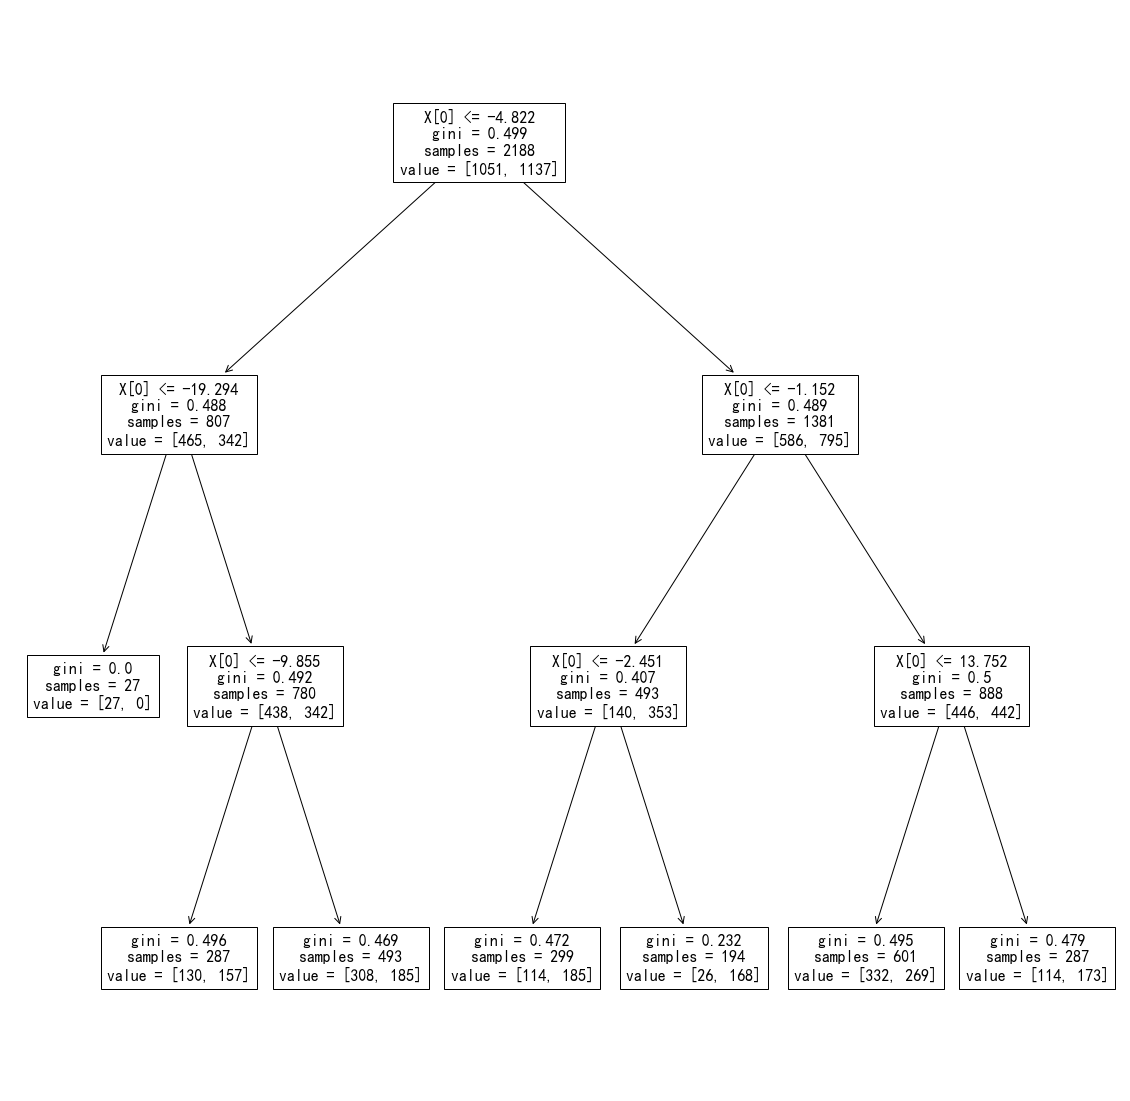

In [210]:
#测试版本
x = tmp_train['日度_MySpic综合钢价指数_DIFF_90_LAG_300']
y = tmp_train['y2'].map(log_map)
x.values.reshape(-1,1)
clf = DecisionTreeClassifier(criterion='gini', max_depth = 3)  
#将Xreshape为一个二维矩阵进行训练
clf.fit(x.values.reshape(-1, 1), y.values)  # 训练决策树
plt.figure(figsize=(20,20))
tree.plot_tree(clf)

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
threshold = clf.tree_.threshold

In [211]:
def tree_f(x,index_list):
    if x < float(index_list[0].left):
        return index_list[0]
    elif x > float(index_list[-1].right):
        return index_list[-1]
    else:
        for idx in index_list:
            if x in idx:
                return idx
        print(x)
        
def tree_fit(feature_list,clf_df, df_fit):
    for feature in feature_list:
        #选出这个变量的分类树评价结果
        tmp_list = clf_df[clf_df['feature'] == feature]
        #将分类结果区间和woe进行映射
        woe_dict = dict(zip(tmp_list['bins'],tmp_list['woe']))
        tmp_list = clf_df[clf_df['feature'] == feature].bins.to_list()
        #将X映射到树的区间上，将区间映射到woe系数上，作为X处理后的结果
        df_fit[feature + '_woe'] = df_fit[feature].apply(lambda x: tree_f(x, tmp_list)) 
        df_fit[feature + '_woe'] = df_fit[feature + '_woe'].map(woe_dict)
    df_fit = df_fit.drop(columns = feature_list)
    return df_fit

#将分箱结果进行运用
feature_list = tree_importance_select
df_before2019 = tree_fit(feature_list, clf_df, df_before2019)
df_after2019 = tree_fit(feature_list, clf_df, df_after2019)
# feature_list

## 4. 模型构建

In [214]:
tmp_train = df_before2019.join(Y).join(df_before2019_noliner)
tmp_test = df_after2019.join(Y).join(df_after2019_noliner)

In [215]:
Y['y2'] = Y['y2'].map(log_map)
tmp_train['y2'] = tmp_train['y2'].map(log_map)
tmp_test['y2'] = tmp_test['y2'].map(log_map)

In [216]:
res = noliner_feature + liner_feature
if 'y2' in res:
    res.remove('y2')
if 'DATE' in res:
    res.remove('DATE')
res

['日度_MySpic综合钢价指数',
 '月度_出口金额:钢材:当月值_DIFF_3',
 'DEBT_ASSET_RATIO_DIFF_3_LAG_8',
 '周度_综合平均价格指数：环渤海动力煤（Q5500K)_DIFF_4_LAG_21',
 'MONETARY_CAP_OVER_SHORT_TERM_LAG_6',
 'k_t_k_t-30',
 '日度_中国铁矿石价格指数(CIOPI)_DIFF_30_LAG_270',
 'OUTSTANDING_DIFF_30_DIFF_90_LAG_300',
 '月度_黑色金属冶炼及压延加工业:亏损企业单位数_DIFF_3_LAG_6',
 '月度_进口金额:钢材:当月值_DIFF_3_LAG_2',
 'DEBT_ASSET_RATIO_DIFF_3_LAG_4',
 'OUTSTANDING_DIFF_30_LAG_60']

In [218]:
tmp_train=tmp_train.dropna()

In [219]:
#划分训练集和测试集
X_train,X_test,Y_train,Y_test = train_test_split(tmp_train[[k for k in tmp_train.columns.values if ('y2' in k)==False]],tmp_train['y2'],test_size = 0.2,random_state = 43,shuffle=False)
res=[k for k in tmp_train.columns.values if ('y2' in k)==False]

In [220]:
# alphas = []
# score = []
# for alpha in tqdm(range(50,1,-1)):
#     alphas.append(alpha/1000)
#     logit = LogisticRegression(penalty= 'l1', C = alpha,solver='liblinear')
#     sc = cross_val_score(logit,X_train[res],Y_train,scoring = "f1", cv = 3)
#     score.append(sc.mean())
# plt.plot(alphas,score)
# plt.show()

In [221]:
# tmp = pd.DataFrame(zip(alphas,score))#alphas
# best = tmp[tmp[1] == tmp[1].max()][0].values[0]
# best

In [222]:
logit = LogisticRegression(penalty= 'l1', C = 0.015,solver='liblinear') #, C = 0.01,solver='liblinear',max_iter = 10000
# logit = LogisticRegression(penalty= 'l2')
result_log = logit.fit(X_train, Y_train) 

fit_log = result_log.predict(X_train)
test_log = result_log.predict(X_test)
pred_log = result_log.predict(tmp_test[res])
tmp = pd.DataFrame(zip(res,result_log.coef_[0]))#
ll = tmp[tmp[1]!=0][0].to_list()
ll.sort()
print(len(res),len(ll))
# tmp[tmp[1]!=0].to_excel('钢铁' + str(cnum) + '|' + str(best) + '.xlsx')

751 52


## 训练

In [223]:
print('分类准确率：',accuracy_score(Y_train,fit_log))
print('混淆矩阵：\n',confusion_matrix(Y_train,fit_log))
print('分类报告：\n',classification_report(Y_train,fit_log))

分类准确率： 0.9779411764705882
混淆矩阵：
 [[260   7]
 [  5 272]]
分类报告：
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       267
           1       0.97      0.98      0.98       277

    accuracy                           0.98       544
   macro avg       0.98      0.98      0.98       544
weighted avg       0.98      0.98      0.98       544



## 测试

In [224]:
print('分类准确率：',accuracy_score(Y_test,test_log))
print('混淆矩阵：\n',confusion_matrix(Y_test,test_log))
print('分类报告：\n',classification_report(Y_test,test_log))

分类准确率： 0.43795620437956206
混淆矩阵：
 [[31 40]
 [37 29]]
分类报告：
               precision    recall  f1-score   support

           0       0.46      0.44      0.45        71
           1       0.42      0.44      0.43        66

    accuracy                           0.44       137
   macro avg       0.44      0.44      0.44       137
weighted avg       0.44      0.44      0.44       137



## 样本外

In [225]:
print('分类准确率：',accuracy_score(tmp_test['y2'],pred_log))
print('混淆矩阵：\n',confusion_matrix(tmp_test['y2'],pred_log))
print('分类报告：\n',classification_report(tmp_test['y2'],pred_log))

分类准确率： 0.535609756097561
混淆矩阵：
 [[355 273]
 [203 194]]
分类报告：
               precision    recall  f1-score   support

           0       0.64      0.57      0.60       628
           1       0.42      0.49      0.45       397

    accuracy                           0.54      1025
   macro avg       0.53      0.53      0.52      1025
weighted avg       0.55      0.54      0.54      1025



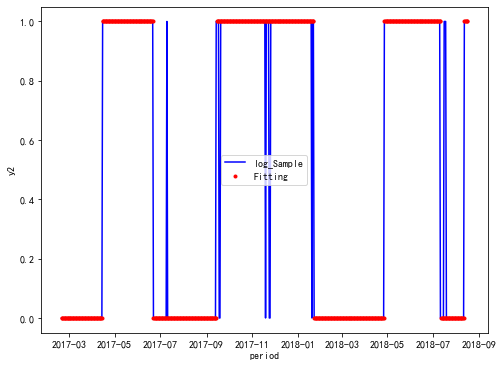

In [226]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Y_train.index, Y_train, color = 'blue', label='log_Sample')##
ax.plot(Y_train.index, fit_log, 'r.',linewidth = 3, label='Fitting')##
ax.legend(loc='best')
plt.xlabel('period')
plt.ylabel('y2')
plt.show()

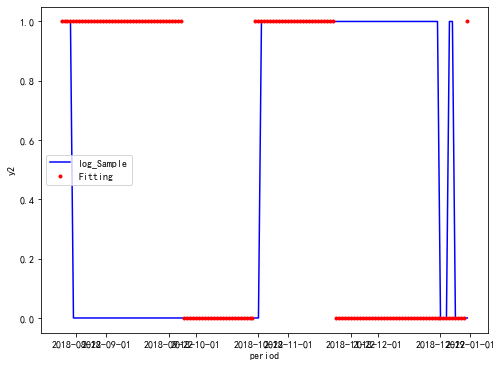

In [227]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Y_test.index, Y_test, color = 'blue', label='log_Sample')##
ax.plot(Y_test.index, test_log, 'r.',linewidth = 3, label='Fitting')##
ax.legend(loc='best')
plt.xlabel('period')
plt.ylabel('y2')
plt.show()

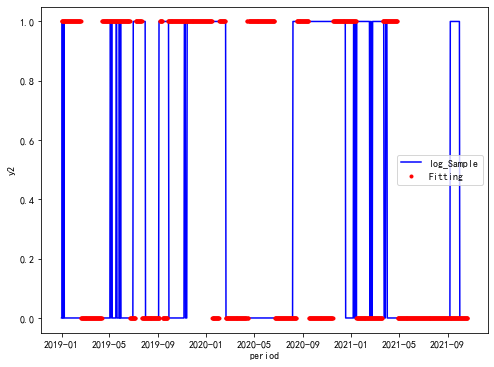

In [228]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.plot(tmp_test.index, tmp_test['y2'], color = 'blue', label='log_Sample')
ax.plot(tmp_test.index, pred_log, 'r.',linewidth = 3, label='Fitting')
ax.legend(loc='best')
plt.xlabel('period')
plt.ylabel('y2')
plt.show()